# This is a notebook for querying the merged Eutro WB for Chl, Oxygen and Nutrients instance for the 1.0.0 Beacon release.
* You can run each cell individually by pressing "shift + enter".
* For more information, questions, bugs, please contact us on Slack:
    + https://join.slack.com/t/beacontechnic-wwa5548/shared_invite/zt-2dp1vv56r-tj_KFac0sAKNuAgUKPPDRg.

#### In order to get access to the Beacon endpoint, you need to fill in your unique personal token between the " " in the cell below.

In [ ]:
Token = ""

#### Install the following packages, if you have not already installed them in your environment:
* pip install requests
* pip install xarray
* pip install ipywidgets
* pip install cartopy
* pip install h5netcdf
* pip install netcdf4
* pip install scipy
* pip install packaging

#### Import the required packages

In [2]:
import requests
import json
import xarray as xr
import datetime
import pandas as pd
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

#### Retrieve the available columns from the Merged TS endpoint
Swagger page here: https://beacon-wb1-ts.maris.nl/swagger/ 

In [ ]:
responseinfo = requests.get("https://beacon-wb2-eutrophication.maris.nl/api/query/available-columns",
                            headers={"Authorization": f"Bearer {Token}"})

params = responseinfo.json()

#### Below you can search through the available columns by entering text between the brackets of search_columns(" ").

In [ ]:
def search_columns(search_term):
    search_term = search_term.lower()
    matches = [col for col in params if search_term in col.lower()]

    if matches:
        print("Matching columns:")
        for match in matches:
            print(match)
    else:
        print("No matching columns found.")


search_columns("")  # Enter your search term here

Matching columns:
COMMON_CHLOROPHYLL
COMMON_CHLOROPHYLL_QC
COMMON_CSR
COMMON_DATE_UPDATE
COMMON_DEPTH
COMMON_DEPTH_P01
COMMON_DEPTH_P06
COMMON_DEPTH_QC
COMMON_EDMERP_CODE
COMMON_EDMO_CODE
COMMON_INSTRUMENT_L05
COMMON_INSTRUMENT_L22
COMMON_LATITUDE
COMMON_LATITUDE_P01
COMMON_LATITUDE_P06
COMMON_LONGITUDE
COMMON_LONGITUDE_P01
COMMON_LONGITUDE_P06
COMMON_OXYGEN
COMMON_OXYGEN_P01
COMMON_OXYGEN_P06
COMMON_OXYGEN_QC
COMMON_OXYGEN_UNITS
COMMON_PLATFORM_B76
COMMON_PLATFORM_C17
COMMON_PLATFORM_L06
COMMON_SALINITY
COMMON_SALINITY_P01
COMMON_SALINITY_P06
COMMON_SALINITY_QC
COMMON_SALINITY_UNITS
COMMON_TEMPERATURE
COMMON_TEMPERATURE_P01
COMMON_TEMPERATURE_P06
COMMON_TEMPERATURE_QC
COMMON_TEMPERATURE_UNITS
COMMON_TIME
CSR platform code
Depth
Depth.units
Depth_qc
EDMO_code
ITS-90 water temperature
ITS-90 water temperature.units
ITS-90 water temperature_qc
Instrument / gear type
Instrument Info
LOCAL_CDI_ID
Latitude
Latitude.units
Longitude
Longitude.units
Originator
P35 Contributor Codes
Platform ty

#### You can define here your input parameters 

In [ ]:
parameter = "COMMON_OXYGEN"  # column name
mindate = "2015-01-01"  # yyyy-mm-dd
maxdate = "2015-06-30"  # yyyy-mm-dd
minlon = -180
maxlon = 180
minlat = -90
maxlat = 90
mindepth = 0
maxdepth = 10

#### This will create the query body based on your input parameters, you can add other "query_parameters" and "filters" to suit your needs. 
* For more query examples and explanations, you can take a look at https://github.com/maris-development/beacon-blue-cloud.  

In [ ]:
def query(parameter, mindate, maxdate, minlon, maxlon, minlat, maxlat, mindepth, maxdepth):
    body = {
        "query_parameters": [
            {
                "column_name": parameter,
                "alias": parameter,
                "skip_fill_values": True
            },
            {
                "column_name": f"{parameter}_UNITS",
                "alias": "Unit"
            },
            {
                "column_name": "COMMON_TIME",
                "alias": "datetime"
            },
            {
                "column_name": f"{parameter}_QC",
                "alias": f"{parameter}_qf"
            },
            {
                "column_name": f"{parameter}_P01",
                "alias": f"{parameter}_P01"
            },
            {
                "column_name": f"{parameter}_P06",
                "alias": f"{parameter}_P06"
            },
            {
                "column_name": "COMMON_DEPTH",
                "alias": "DEPTH"
            },
            {
                "column_name": "COMMON_LONGITUDE",
                "alias": "LONGITUDE"
            },
            {
                "column_name": "COMMON_LATITUDE",
                "alias": "LATITUDE"
            },
            {
                "column_name": "SOURCE_BDI",
                "alias": "SOURCE_BDI"
            },
            {
                "column_name": "SOURCE_BDI_DATASET_ID",
                "alias": "SOURCE_BDI_DATASET_ID"
            }
        ],
        "filters": [
            {
                "for_query_parameter": "datetime",
                "min": f"{mindate}T00:00:00",
                "max": f"{maxdate}T00:00:00",
                "cast": "timestamp"
            },
            {
                "for_query_parameter": "DEPTH",
                "min": mindepth,
                "max": maxdepth
            },
            {
                "for_query_parameter": "LONGITUDE",
                "min": minlon,
                "max": maxlon
            },
            {
                "for_query_parameter": "LATITUDE",
                "min": minlat,
                "max": maxlat
            }
        ],
        "output": {
            "format": "netcdf"
        }}
    return body


query_body = query(parameter, mindate, maxdate, minlon,
                   maxlon, minlat, maxlat, mindepth, maxdepth)

#### This is the post request that is sent to Beacon with the above specified body.

In [ ]:
response = requests.post("https://beacon-wb2-eutrophication.maris.nl/api/query", json.dumps(query_body), headers={
    "Authorization": f"Bearer {Token}",
    "Content-type": "application/json"
})

if response.status_code == 204:
    print("No data has been found for your query, please update your input fields above and run the notebook again.")
elif response.status_code != 200:
    print(response.text)

In [ ]:
regionname = f"[{minlat},{minlon}],[{maxlat},{maxlon}]"

if not os.path.exists("./Beacon_V1.0.0_Output"):
    os.makedirs("Beacon_V1.0.0_Output")

open(
    f"./Beacon_V1.0.0_Output/EWB_merged_{parameter}_{regionname}_{mindate}-{maxdate}_[{mindepth}-{maxdepth}m].nc", "wb").write(response.content)
df = xr.open_dataset(
    f"./Beacon_V1.0.0_Output/EWB_merged_{parameter}_{regionname}_{mindate}-{maxdate}_[{mindepth}-{maxdepth}m].nc").to_dataframe()
df = df.assign(datetime=pd.to_datetime(
    df["datetime"])).set_index("datetime").sort_index()
df

,COMMON_OXYGEN,Unit,COMMON_OXYGEN_qf,COMMON_OXYGEN_P01,COMMON_OXYGEN_P06,DEPTH,LONGITUDE,LATITUDE,SOURCE_BDI,SOURCE_BDI_DATASET_ID,dataset_id
datetime,,,,,,,,,,,
2015-01-01 12:32:00,228.597916,umol/l,1,DOXMZZXX,KGUM,1.390367,-26.975128,30.910919,BEACON-EMODNET-CHEMISTRY,28610.0,87.0
2015-01-01 12:32:00,228.633072,umol/l,1,DOXMZZXX,KGUM,9.930987,-26.975128,30.910919,BEACON-EMODNET-CHEMISTRY,28610.0,87.0
2015-01-01 12:32:00,228.687485,umol/l,1,DOXMZZXX,KGUM,9.037218,-26.975128,30.910919,BEACON-EMODNET-CHEMISTRY,28610.0,87.0
2015-01-01 12:32:00,228.629486,umol/l,1,DOXMZZXX,KGUM,8.143445,-26.975128,30.910919,BEACON-EMODNET-CHEMISTRY,28610.0,87.0
2015-01-01 12:32:00,228.601410,umol/l,1,DOXMZZXX,KGUM,7.150359,-26.975128,30.910919,BEACON-EMODNET-CHEMISTRY,28610.0,87.0
...,...,...,...,...,...,...,...,...,...,...,...
2015-06-29 22:01:00,236.449203,umol/l,1,DOXMZZXX,KGUM,6.947655,-31.825989,37.770000,BEACON-EMODNET-CHEMISTRY,27825.0,169.0
2015-06-29 22:01:00,236.441833,umol/l,1,DOXMZZXX,KGUM,5.955148,-31.825989,37.770000,BEACON-EMODNET-CHEMISTRY,27825.0,169.0
2015-06-29 22:01:00,236.433380,umol/l,1,DOXMZZXX,KGUM,4.962635,-31.825989,37.770000,BEACON-EMODNET-CHEMISTRY,27825.0,169.0


#### Optionally apply a filter on your parameter for quick removal of outliers. Note that this can also be achieved within your Beacon request by applying a filter on your parameter. 

In [ ]:
# highbound = 40
# lowbound = -2
# df = df.loc[(df[f"{parameter}"] < highbound) & (df[f"{parameter}"] > lowbound)]
# df

In [47]:
df.head()

,COMMON_OXYGEN,Unit,COMMON_OXYGEN_qf,COMMON_OXYGEN_P01,COMMON_OXYGEN_P06,DEPTH,LONGITUDE,LATITUDE,SOURCE_BDI,SOURCE_BDI_DATASET_ID,dataset_id
datetime,,,,,,,,,,,
2015-01-01 12:32:00,228.597916,umol/l,1,DOXMZZXX,KGUM,1.390367,-26.975128,30.910919,BEACON-EMODNET-CHEMISTRY,28610.0,87.0
2015-01-01 12:32:00,228.633072,umol/l,1,DOXMZZXX,KGUM,9.930987,-26.975128,30.910919,BEACON-EMODNET-CHEMISTRY,28610.0,87.0
2015-01-01 12:32:00,228.687485,umol/l,1,DOXMZZXX,KGUM,9.037218,-26.975128,30.910919,BEACON-EMODNET-CHEMISTRY,28610.0,87.0
2015-01-01 12:32:00,228.629486,umol/l,1,DOXMZZXX,KGUM,8.143445,-26.975128,30.910919,BEACON-EMODNET-CHEMISTRY,28610.0,87.0
2015-01-01 12:32:00,228.601410,umol/l,1,DOXMZZXX,KGUM,7.150359,-26.975128,30.910919,BEACON-EMODNET-CHEMISTRY,28610.0,87.0


#### Plotting of results.

In [ ]:
import plotly.express as px

lon = df['LONGITUDE']
lat = df['LATITUDE']
field = df[f'{parameter}']
depth = df['DEPTH']

# fig = px.scatter_mapbox(df, lon=lon, lat=lat, color=field, hover_name=df['Depth'], color_continuous_scale = px.colors.sequential.Rainbow, zoom=3, height=500)
fig = px.scatter_mapbox(df, lon=lon, lat=lat, color=field, size=depth, size_max=10, hover_data='COMMON_OXYGEN_qf',
                        hover_name=df['SOURCE_BDI'], color_continuous_scale=px.colors.sequential.Rainbow, zoom=3, height=800)
fig.update_layout(
    title=dict(
        text=f'EWB_Merged_Beacon_instance {parameter} {regionname} {mindate}-{maxdate} [{mindepth}-{maxdepth}m] #Points = {len(df)}'),
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
    ])

fig.show()

In [50]:
print(min(lon))
print(max(lon))
print(min(lat))
print(max(lat))

-32.587006
-1.274506
29.16362
47.933998


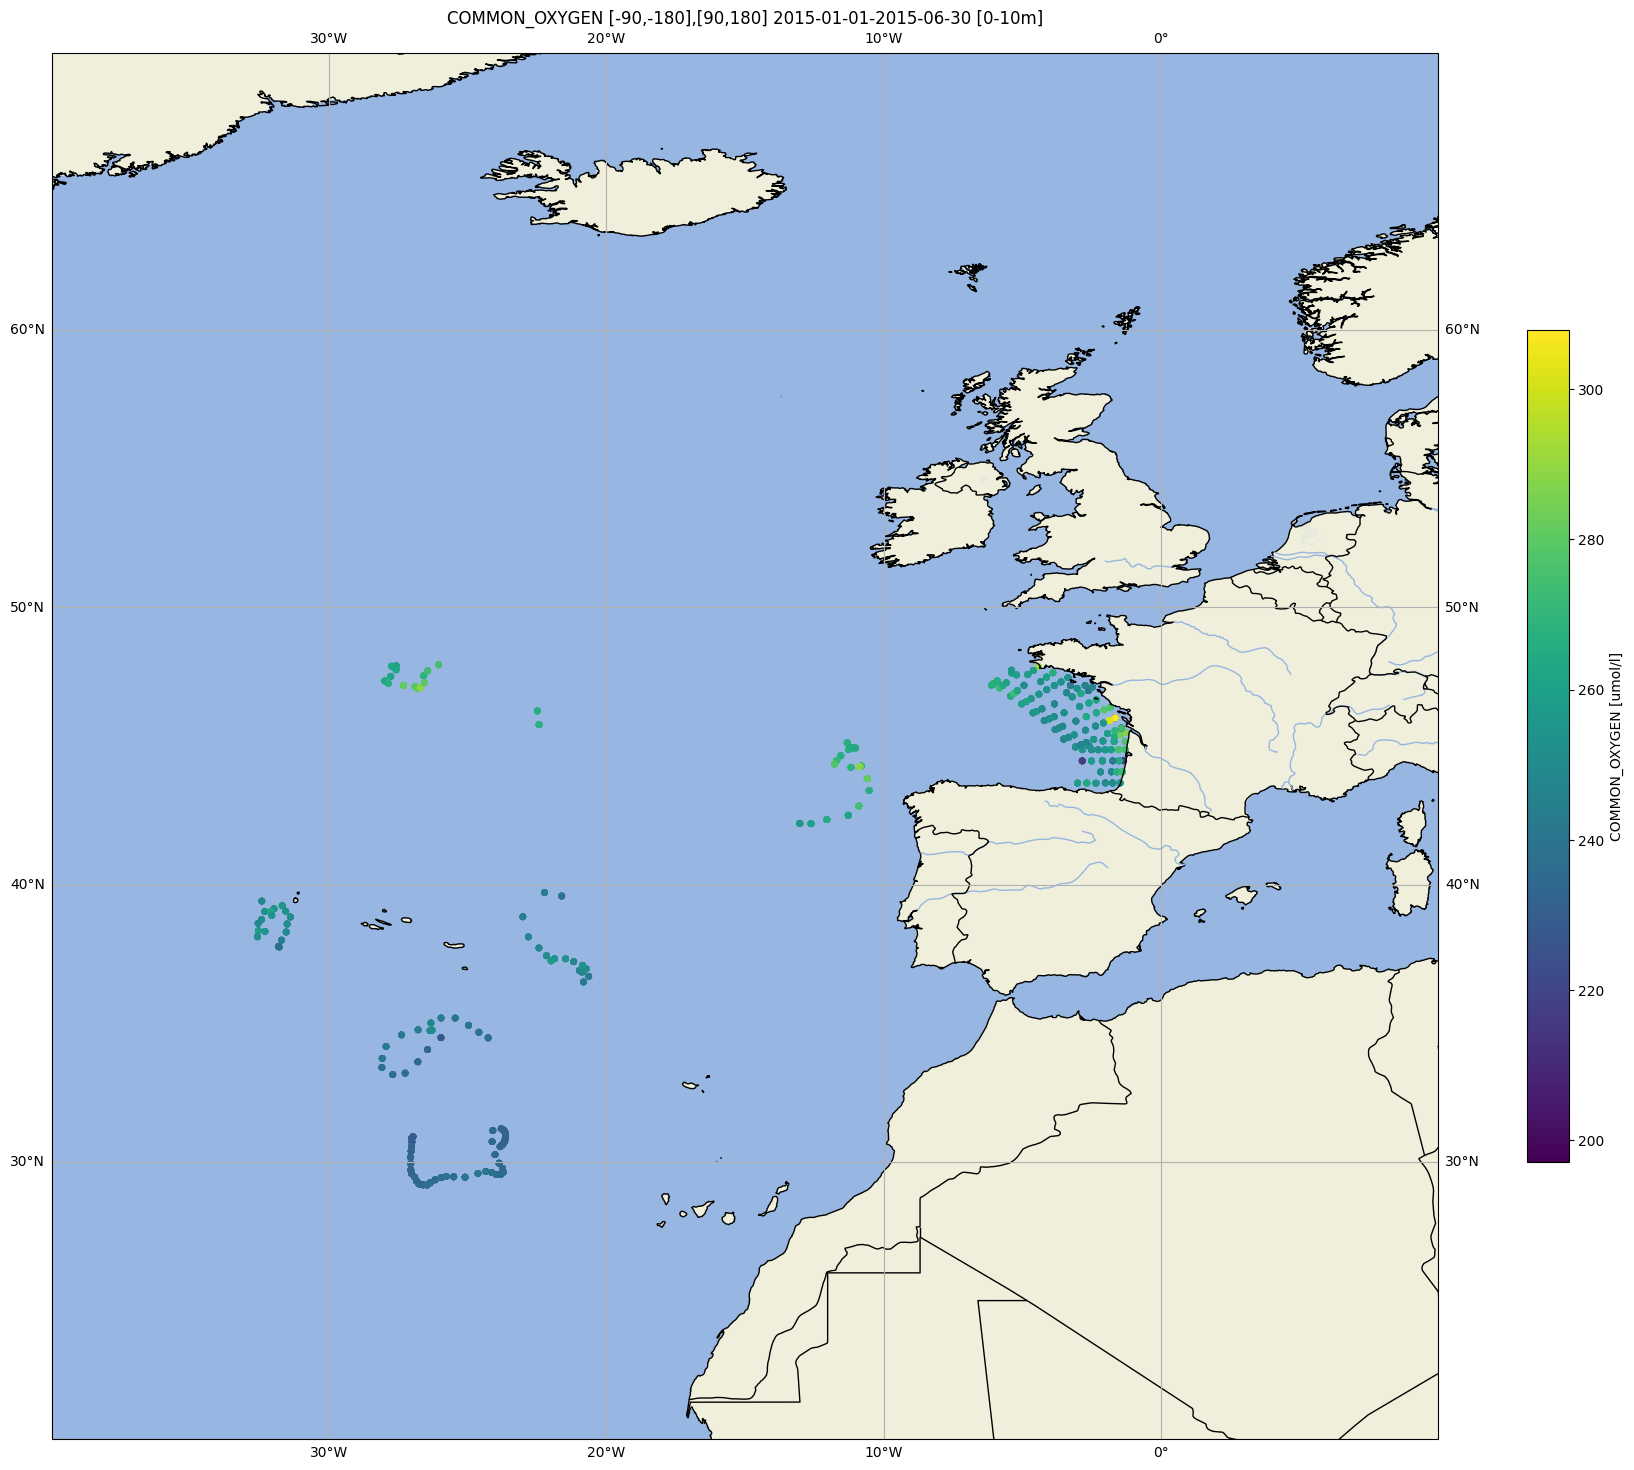

In [51]:
fig = plt.figure(figsize=(23, 18))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-40, 10, 20, 70], crs=ccrs.PlateCarree())  # (west, east, south, north)

ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)

sc = ax.scatter(df["LONGITUDE"], df["LATITUDE"], c=df[parameter], cmap="viridis", s=15, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)     
ax.add_feature(cfeature.BORDERS)   
ax.add_feature(cfeature.LAKES, alpha=0.1) 

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6, label="Value Set 1")
cbar.set_label(f"{parameter} [{df["Unit"].iloc[0]}]")

plt.title(f"{parameter} {regionname} {mindate}-{maxdate} [{mindepth}-{maxdepth}m]")

plt.show()